In [32]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from vgg_models.vgg import vgg13_bn
from vgg_models.densenet import densenet169
from vgg_models.resnet import resnet50

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- list of altered datasets -------
altered_datasets = ['cifar10_permuted_block_size_8.pth', 'cifar10_permuted_block_size_16.pth', 'cifar10_fgsa_VGG.pth', 'cifar10_fgsa_MLP.pth', 'cifar10_fgsa_resnet50.pth', 'cifar10_fgsa_densenet169.pth', 'cifar10_pgd_VGG_eps_5.pth', 'cifar10_fgsa_densenet169_eval_10.pth']

# ---------- Load the CIFAR-10 test dataset -------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#--------- Load the altered dataset ----------

class CustomDataset(Dataset):
    def __init__(self, dataset_dict, transform = None):
        self.dataset_dict = dataset_dict
        self.transform = transform

    def __len__(self):
        return len(self.dataset_dict)

    def __getitem__(self, index):
        data = self.dataset_dict[index]
        image = data['image']
        if self.transform:
            image = self.transform(data['image'])
        label = data['label']

        return image, label

# Load the dataset dictionary, choose from the altered_datasets list
loaded_dataset = torch.load(altered_datasets[-1])

# Create an instance of the CustomDataset
altered_dataset = CustomDataset(loaded_dataset, transform = transform)
altered_loader = DataLoader(altered_dataset, batch_size=1024, shuffle=False)

# ------------- Load the pretrained model ------------
pretrained_model = resnet50(pretrained=True) # choose from the different models: vgg13_bn, densenet169, resnet50
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()


# -----------calculate accuracies -----------

def accuracy_calc(loader, classes, dataset):
    num_classes = len(classes)
    # Initialize a dictionary to store per-class counts
    class_counts = {class_idx: {'correct': 0, 'total': 0} for class_idx in range(num_classes)}

    with torch.no_grad():
        for inputs, labels in loader:

            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update counts for each class
            for class_idx in range(num_classes):
                class_mask = labels == class_idx
                class_total = class_mask.sum().item()
                class_correct = (predicted[class_mask] == class_idx).sum().item()

                class_counts[class_idx]['correct'] += class_correct
                class_counts[class_idx]['total'] += class_total

    # Calculate per-class accuracy
    per_class_accuracy = {class_idx: class_counts[class_idx]['correct'] / class_counts[class_idx]['total']
                        for class_idx in range(num_classes)}

    # Print per-class accuracy
    total_accuracy = 0
    for class_idx in range(num_classes):
        print(f'{dataset} accuracy for {classes[class_idx]}: {100 * per_class_accuracy[class_idx]:.2f}%') 
        total_accuracy += per_class_accuracy[class_idx]

    print(f'{dataset} total accuracy: {100 * total_accuracy/10:.2f}%')

classes  = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
accuracy_calc(test_loader, classes, 'CIFAR10')
#accuracy_calc(altered_loader, classes, 'Permuted CIFAR10')


Files already downloaded and verified
CIFAR10 accuracy for Airplane: 94.50%
CIFAR10 accuracy for Car: 97.00%
CIFAR10 accuracy for Bird: 91.70%
CIFAR10 accuracy for Cat: 85.30%
CIFAR10 accuracy for Deer: 94.60%
CIFAR10 accuracy for Dog: 91.10%
CIFAR10 accuracy for Frog: 95.00%
CIFAR10 accuracy for Horse: 95.50%
CIFAR10 accuracy for Ship: 96.10%
CIFAR10 accuracy for Truck: 95.70%
CIFAR10 total accuracy: 93.65%


Files already downloaded and verified


TypeError: Invalid shape (3, 32, 32) for image data

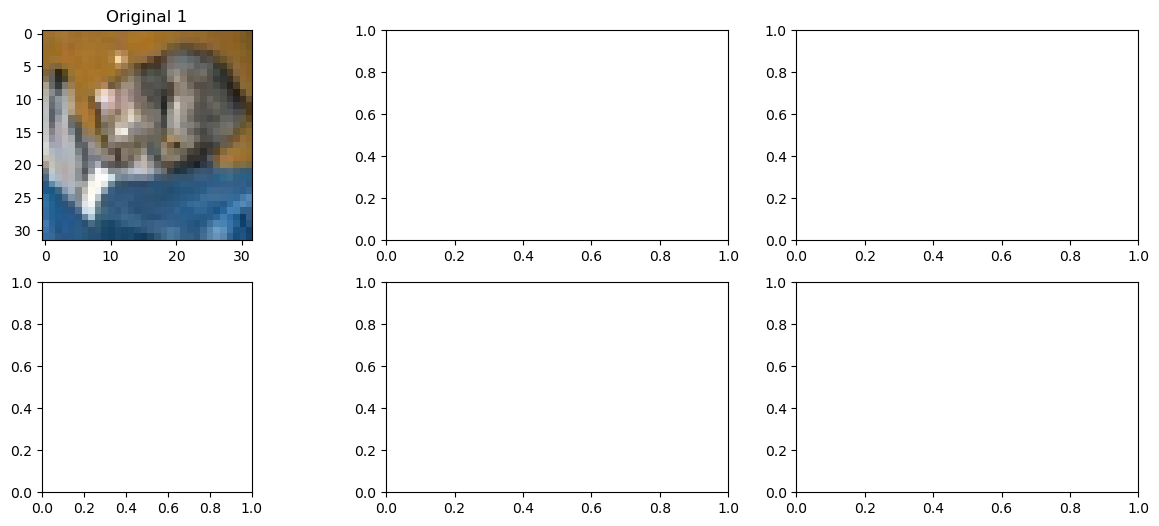

In [29]:
import matplotlib.pyplot as plt
import numpy as np

altered_datasets = ['cifar10_permuted_block_size_8.pth', 'cifar10_permuted_block_size_16.pth', 'cifar10_fgsa_VGG.pth', 'cifar10_fgsa_MLP.pth', 'cifar10_fgsa_resnet50.pth', 'cifar10_fgsa_densenet169.pth', 'cifar10_pgd_VGG_eps_5.pth', 'cifar10_fgsa_vgg13_bn_eval_10.pth','cifar10_pgd_VGG.pth']

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
loaded_dataset = torch.load(altered_datasets[-1])
t = transforms.Compose([transforms.ToTensor()])
altered_dataset = CustomDataset(loaded_dataset, transform = t)


# Create a subplot for each image
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i in range(3):
    # Original image
    original_image, _ = test_dataset[i]
    axes[0, i].imshow(np.array(original_image))
    axes[0, i].set_title(f'Original {i + 1}')

    # Altered image
    altered_image, _ = altered_dataset[i]
    axes[1, i].imshow(np.array(altered_image))
    axes[1, i].set_title(f'Altered {i + 1}')

# Hide the axes
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()


In [30]:
print(altered_dataset[0][0])

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.

In [9]:
print(altered_dataset[0][0])

<PIL.Image.Image image mode=RGB size=32x32 at 0x1204F34D0>
